In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import scipy.stats as stats
import platform

if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
else:
    plt.rc('font', family = 'Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

import Modeling_test
import imp
imp.reload(Modeling_test)
from Modeling_test import RFmodeling

In [2]:
# 날짜 정보가 있는 데이터
data = pd.read_csv('최종_동태.csv')
data.index = pd.to_datetime(data['회계년도'])
data.drop('회계년도', axis=1, inplace=True)

In [3]:
## feature selection을 통해 선택된 원래의 train data
df_train_original = pd.read_csv('동태3겹rus_train_origin.csv')
x_columns = list(df_train_original.drop(['부실여부'], axis=1).columns)
x_columns_target = list(df_train_original.columns)
len(x_columns_target)

18

In [4]:
### 학습데이터, 테스트 데이터로 분할
data_test = data[data.index >= datetime.strptime('2021-12-01', '%Y-%m-%d')]
data_train = data[data.index < datetime.strptime('2021-12-01', '%Y-%m-%d')]

# 회사명과 거래소 코드  정보를 남겨놓기 위한거
data_name = data_train[['회사명', '거래소코드']]

In [5]:
# 원래 데이터와 생성된 가짜 데이터가 섞여있는거
df_train_temp = pd.read_csv('동태3겹rus_train_1.csv')

In [6]:
# 진짜 데이터에 날짜 데이터 부여
df_train_original.index = data_train.index

In [7]:
# 테스트 데이터 불러오기
df_test = pd.read_csv('최종_동태_test.csv')
df_test.index = pd.to_datetime(df_test['회계년도'])
df_test.drop('회계년도', axis=1, inplace=True)

In [8]:
# 'index'라는 새로운 열에 원래 인덱스 저장
df_train_original['index'] = df_train_original.index

# 이제 merge()를 호출하면 'index' 열이 유지됩니다.
df_train = df_train_original[x_columns_target + ['index']].merge(df_train_temp[x_columns_target], how='inner')
df_train.set_index('index', inplace=True)

In [9]:
from imblearn.under_sampling import RandomUnderSampler

x = df_test[x_columns]
y = df_test['부실여부']

# 다수 클래스와 소수 클래스로 분리합니다.
majority_class = df_test[df_test['부실여부'] == 0]
minority_class = df_test[df_test['부실여부'] == 1]

# 다수 클래스의 비율을 원하는대로 설정합니다.
ratio = 1  # 10:1 비율로 설정 예시


# 다수 클래스의 비율에 따라 원하는 샘플 개수를 계산합니다.
num_samples_to_keep = len(minority_class) * ratio

# RandomUnderSampler를 사용하여 언더샘플링합니다.
rus = RandomUnderSampler(sampling_strategy={0: num_samples_to_keep})
x_resampled, y_resampled = rus.fit_resample(x, y)

# 언더샘플링된 데이터프레임을 생성합니다.
df_test_resampled = pd.DataFrame(x_resampled, columns=x.columns)
df_test_resampled['부실여부'] = y_resampled

In [10]:
df_test_resampled['부실여부'].value_counts()

부실여부
0.0    1788
1.0    1788
Name: count, dtype: int64

In [11]:
rf = RFmodeling(df_train, df_test_resampled, x_columns)

In [14]:
#### 여기는 csv 파일 불러오는거니 일단은 신경 안써도 됨
param_info = pd.read_csv('RF_동태3겹_rus1.csv').drop(['params_index'], axis=1)
param_dict = {}
for column in param_info:
    param_dict[column] = param_info[column].iloc[0]
param_dict

{'n_estimators': 150, 'max_features': 0.7, 'max_depth': 10}

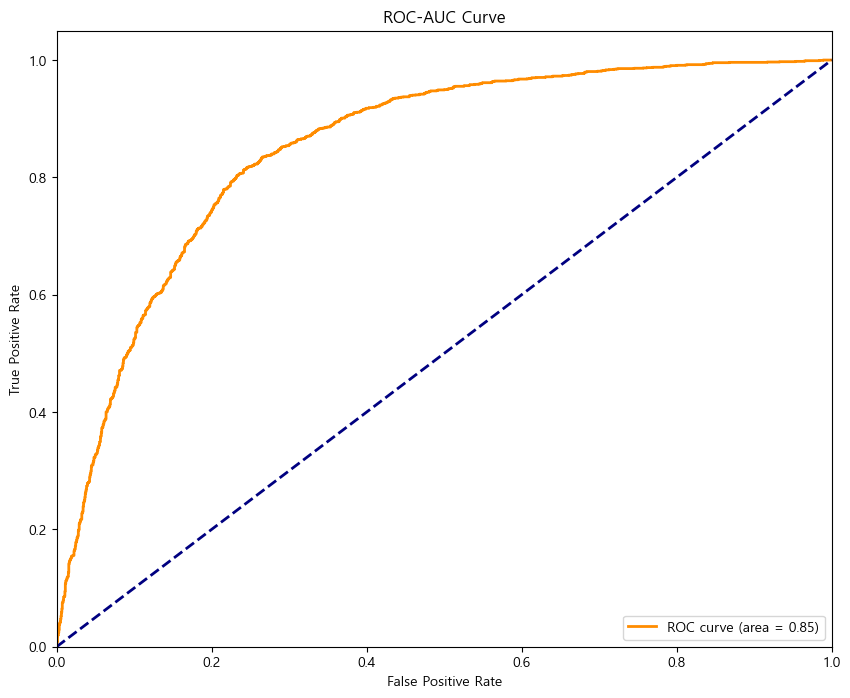

Threshold : 0.39353258694848925
혼돈행렬 : [[1268  520]
 [ 264 1524]]
정확도 : 0.7808
정밀도 : 0.7456
재현율 : 0.8523
roc_auc 스코어 : 0.8496
f1 스코어 : 0.7954
f2 스코어 : 0.8286




In [15]:
rf.my_modeling(param_dict)